Locked ω from stalagmites: 2 


infer.timedeppar (timedeppar 1.0.3 2023-08-28): starting new Markov Chain

  number of constant parameters:          65

  number of time-dependent parameters:    1

  number of estimated process parameters: 3



* proposal distribution of constant parameters:
correlation matrix:
        sigma_y A1 phi1 A2 phi2 A3 phi3 A4 phi4 A5 phi5 A6 phi6 A7 phi7 A8 phi8
sigma_y       1  0    0  0    0  0    0  0    0  0    0  0    0  0    0  0    0
A1            0  1    0  0    0  0    0  0    0  0    0  0    0  0    0  0    0
phi1          0  0    1  0    0  0    0  0    0  0    0  0    0  0    0  0    0
A2            0  0    0  1    0  0    0  0    0  0    0  0    0  0    0  0    0
phi2          0  0    0  0    1  0    0  0    0  0    0  0    0  0    0  0    0
A3            0  0    0  0    0  1    0  0    0  0    0  0    0  0    0  0    0
phi3          0  0    0  0    0  0    1  0    0  0    0  0    0  0    0  0    0
A4            0  0    0  0    0  0    0  1    0  0    0  0    0  0    0  0    0
phi4          0  0    0  0    0  0    0  0    1  0    0  0    0  0    0  0    0
A5            0  0    0  0    0  0    0  0    0  1    0  0    0  0    0  0    0
phi5          0  0    0  0    0  0    0  0    0  0  

1000 iterations completed

  acceptance frequency of constant parameters:             0.103

  acceptance frequencies of time-dependent parameters:     0.0286

  acceptance frequencies of Ornstein-Uhlenbeck parameters: 0.04

plot.timedeppar (timedeppar 1.0.3 2023-08-28): plotting inference results: traces,time-series



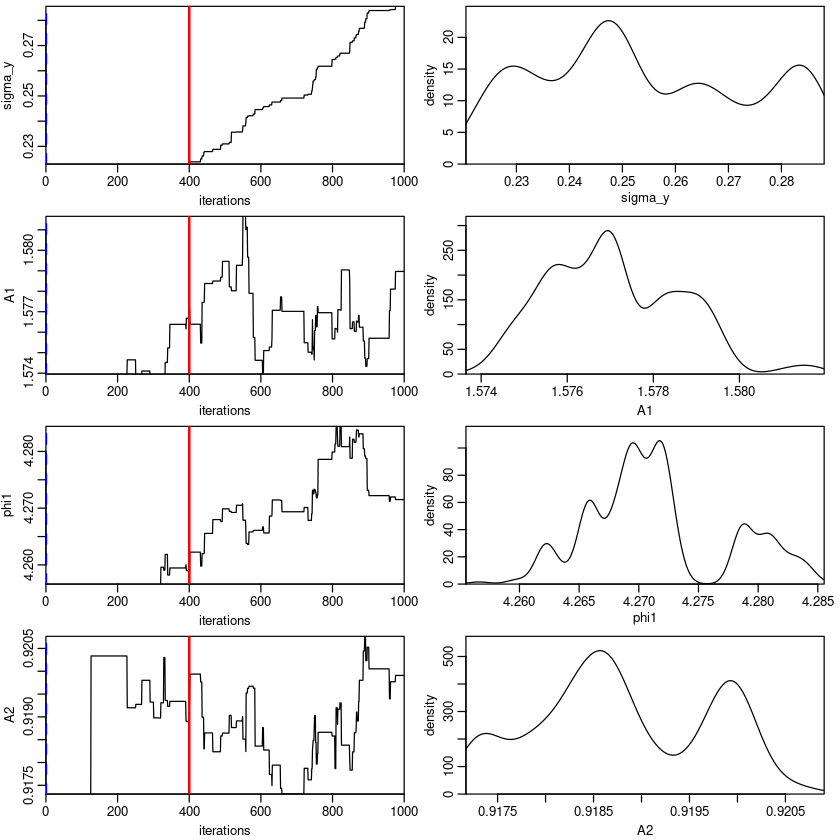

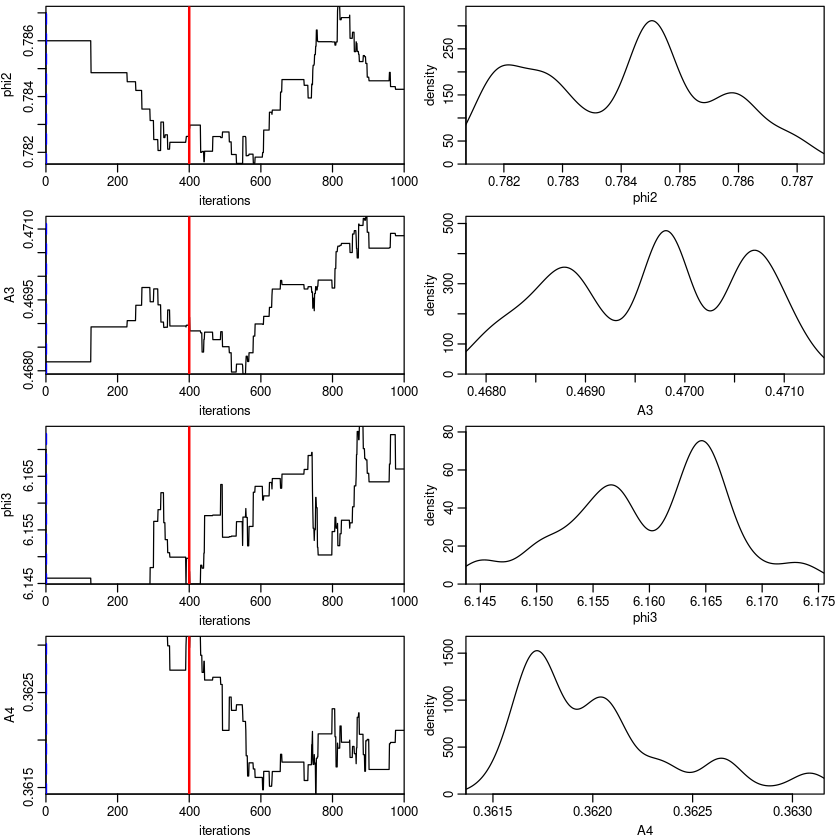

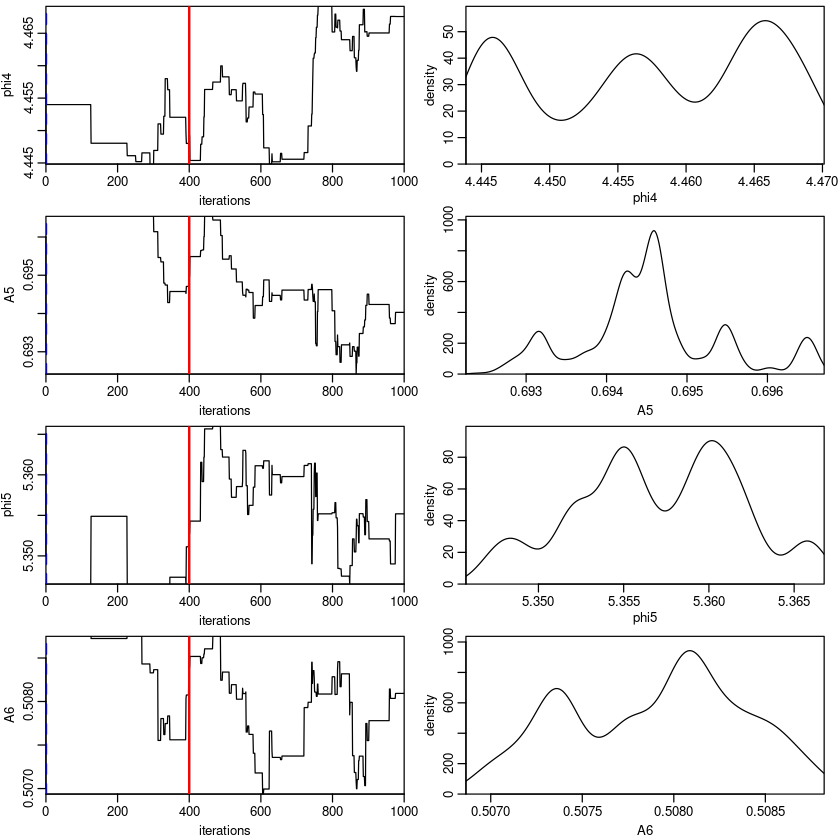

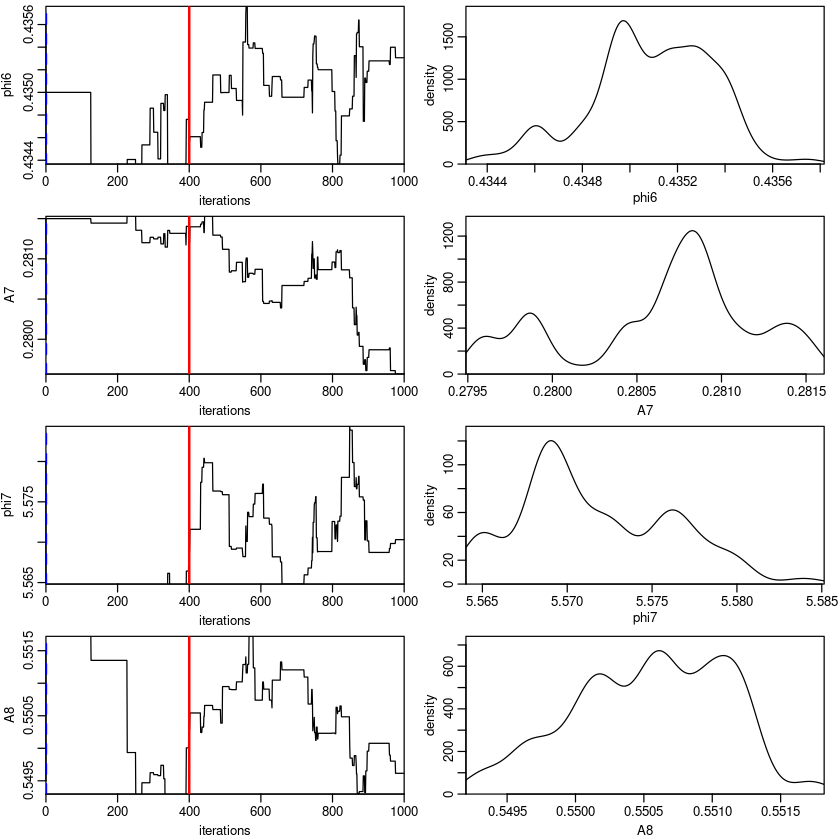

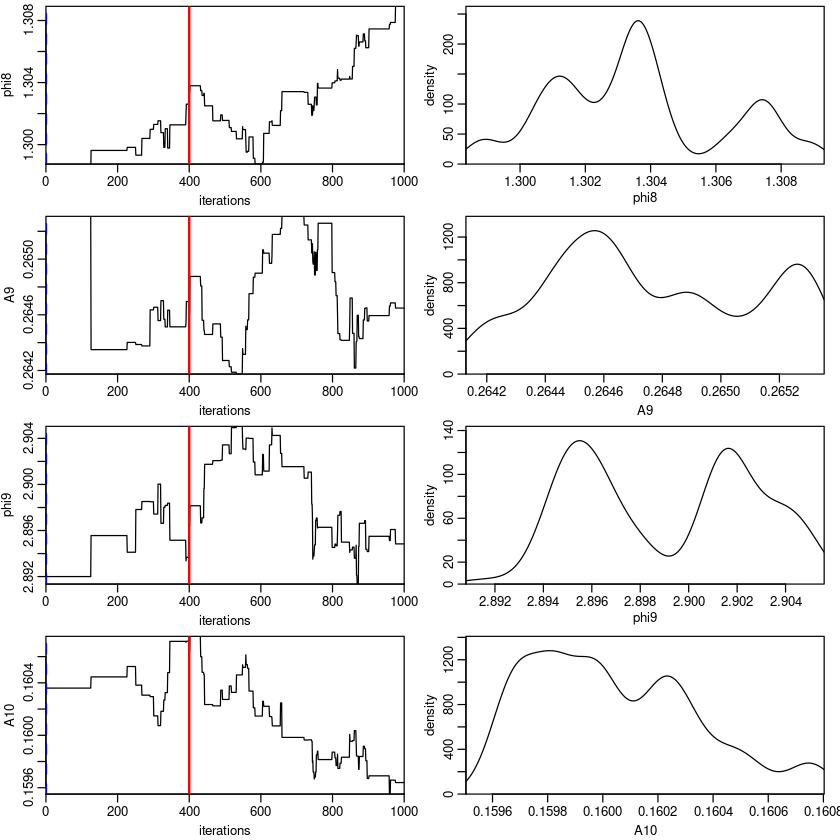

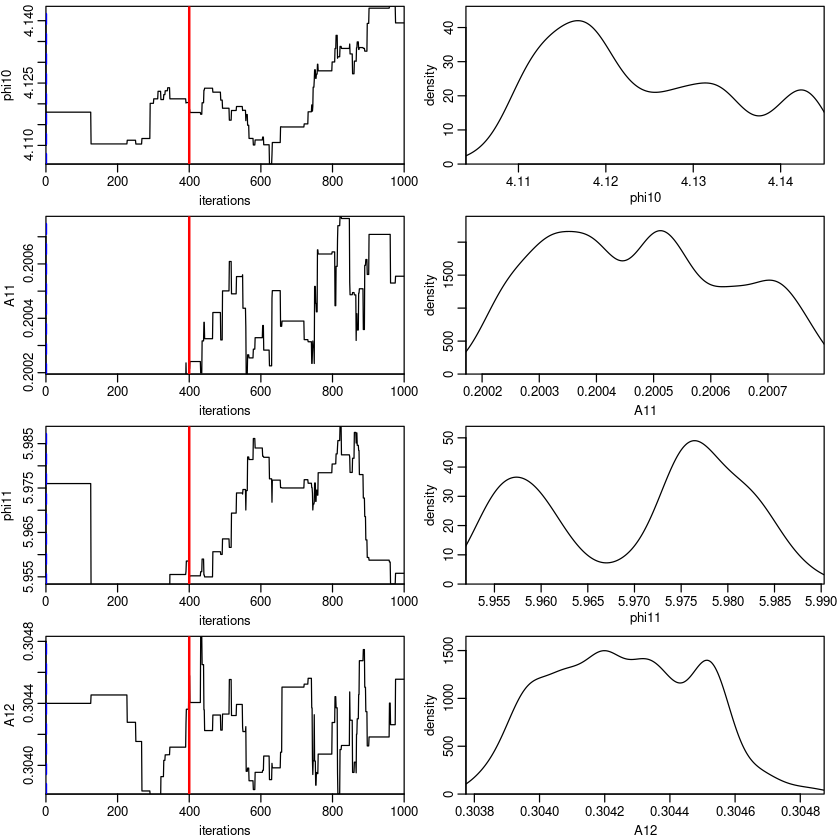

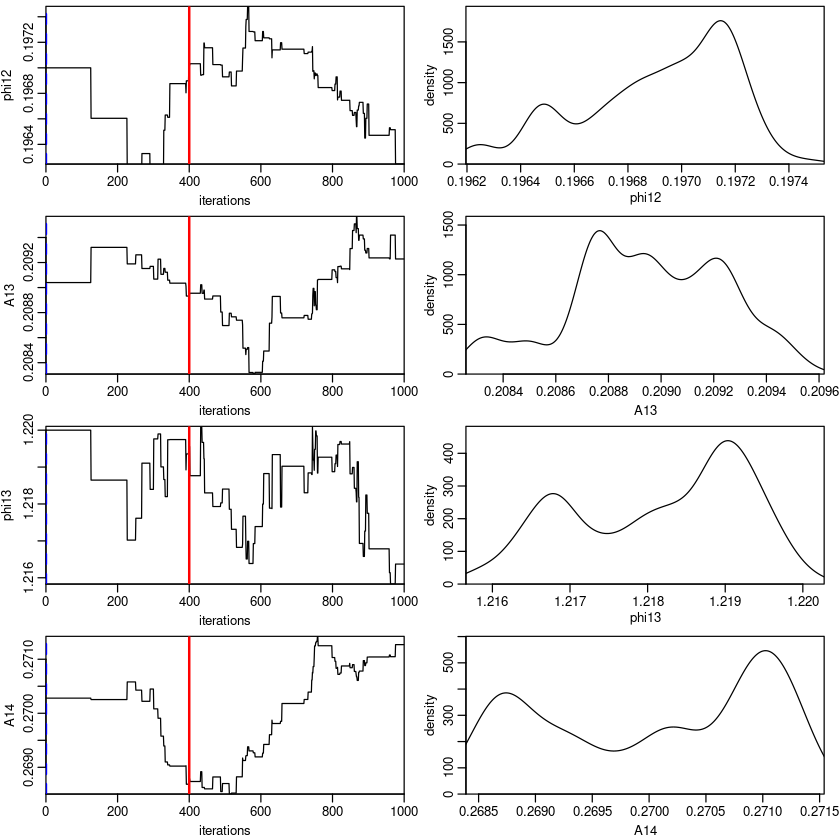

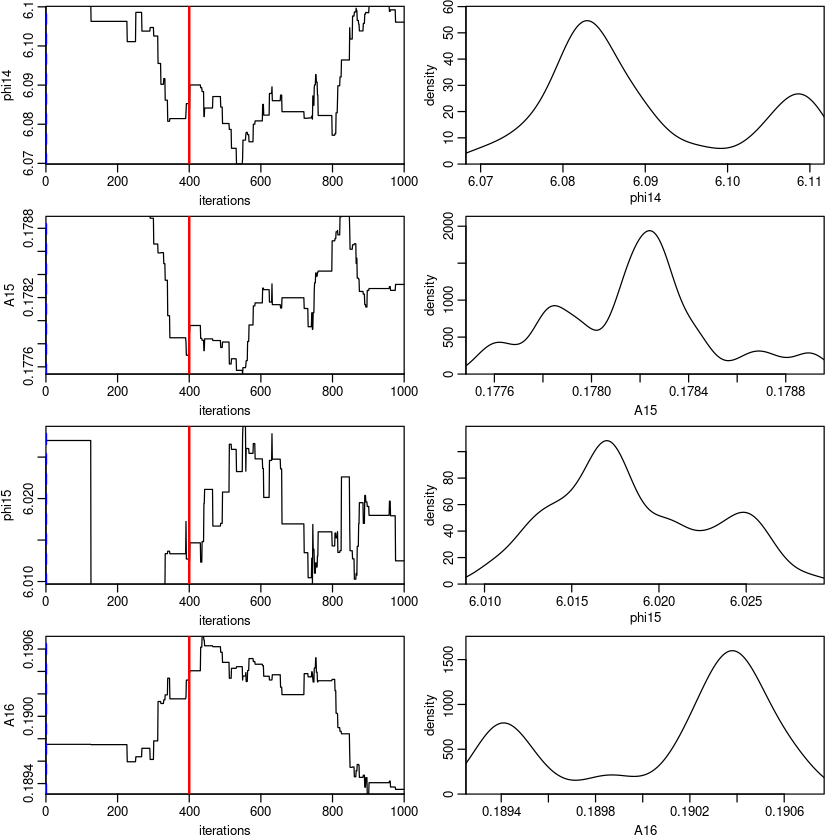

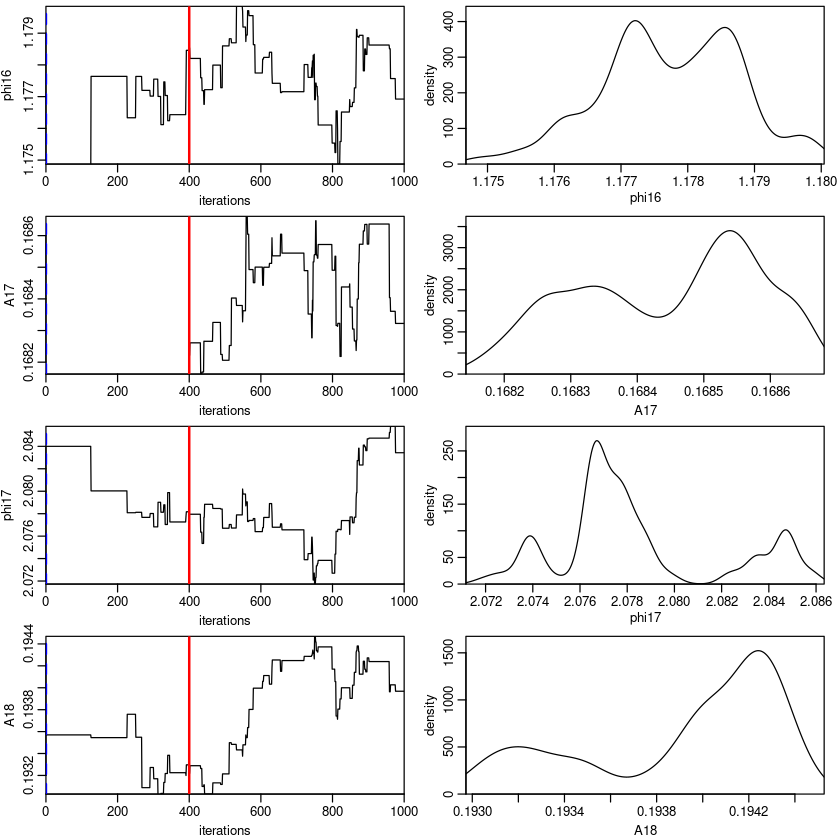

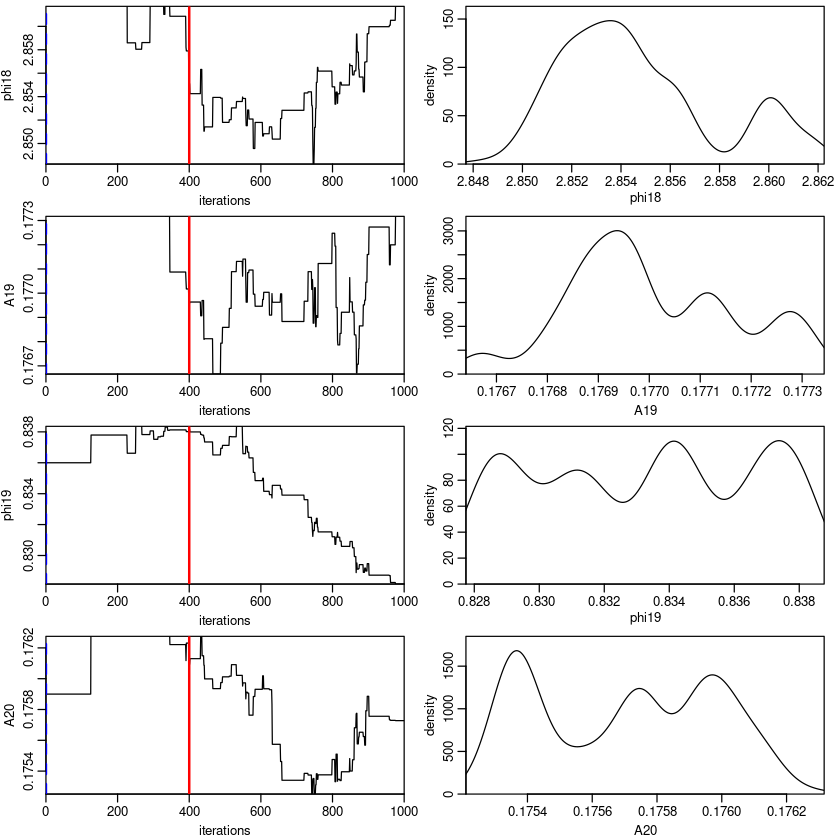

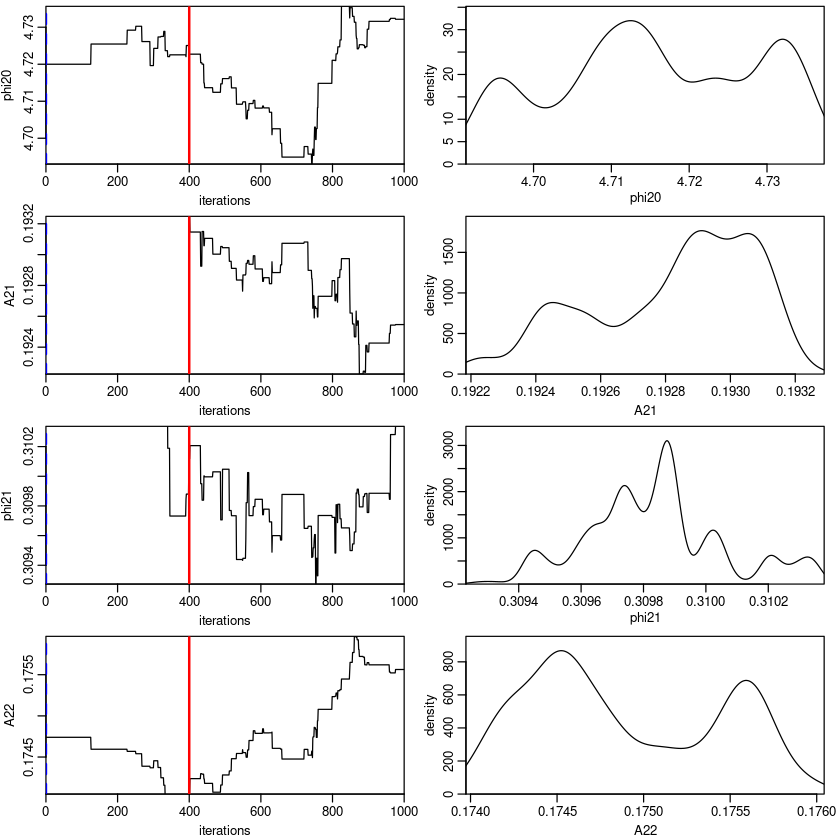

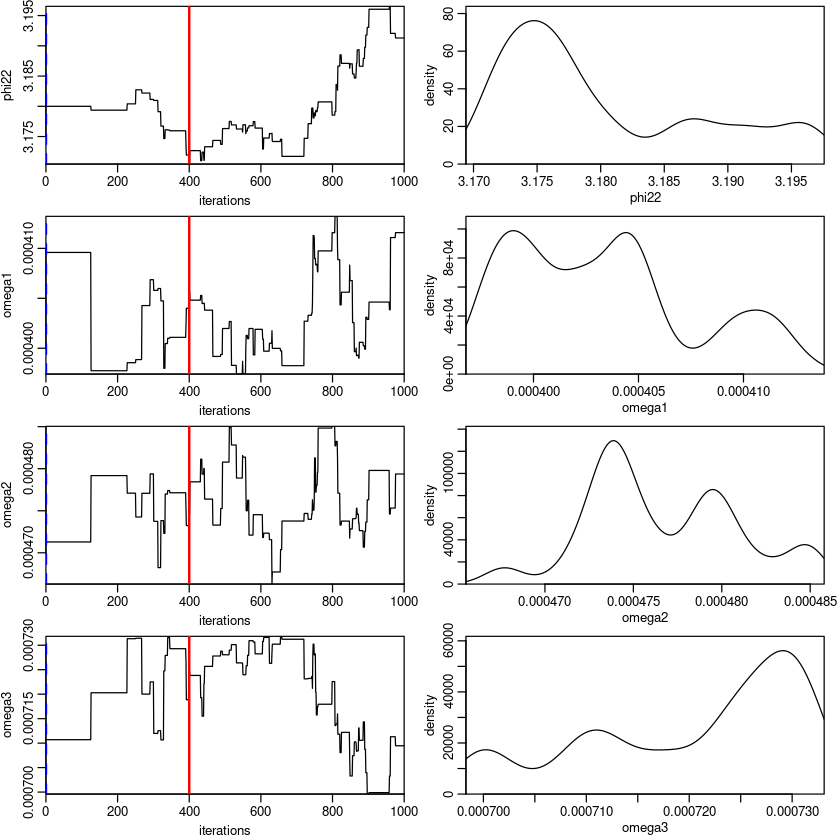

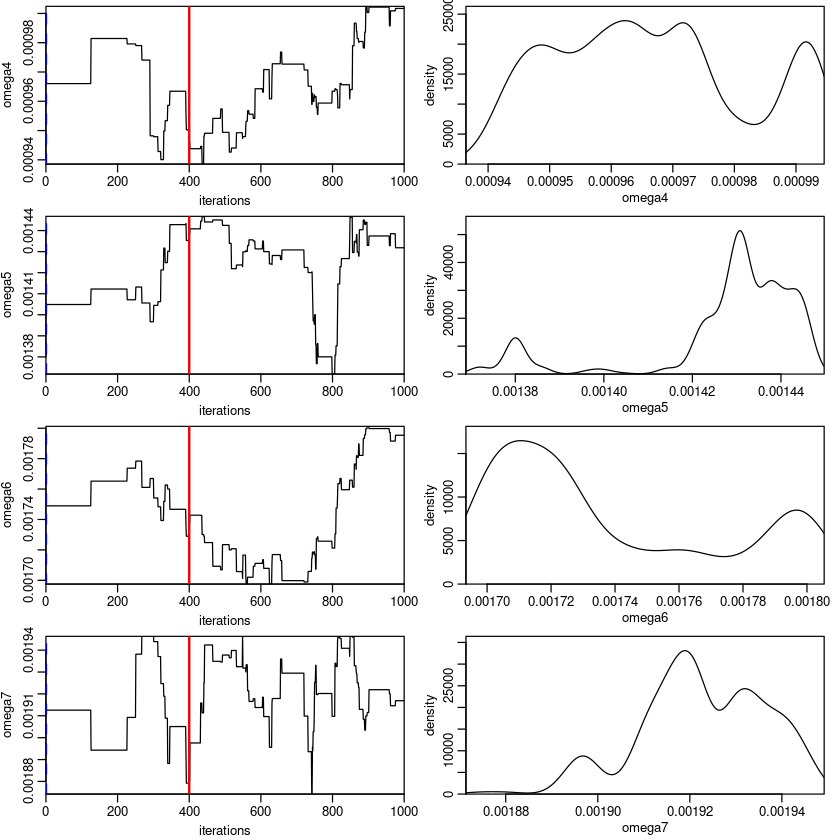

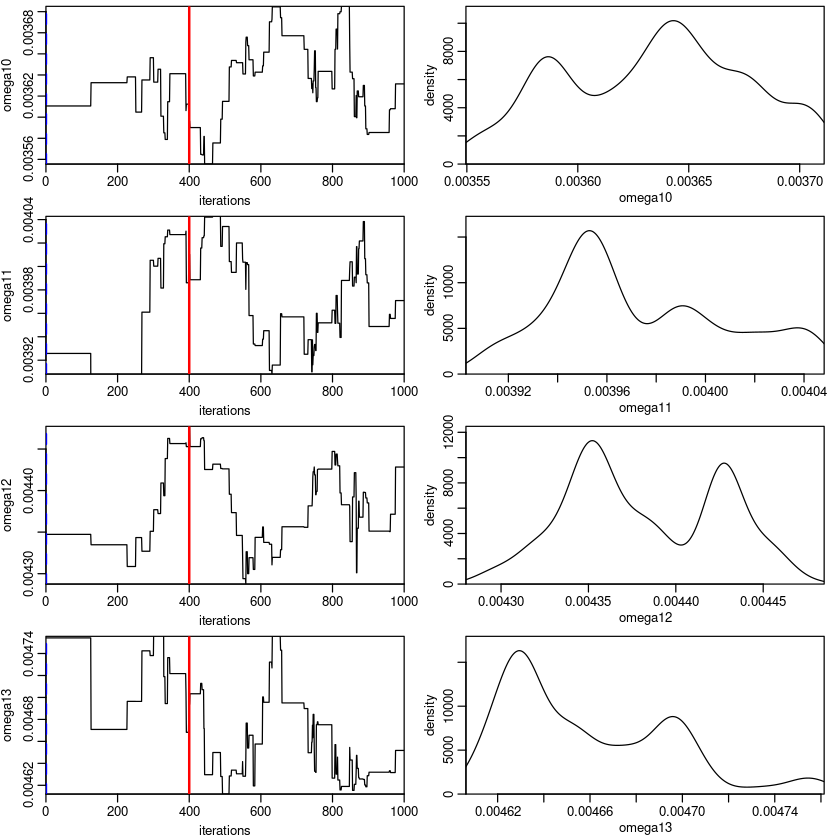

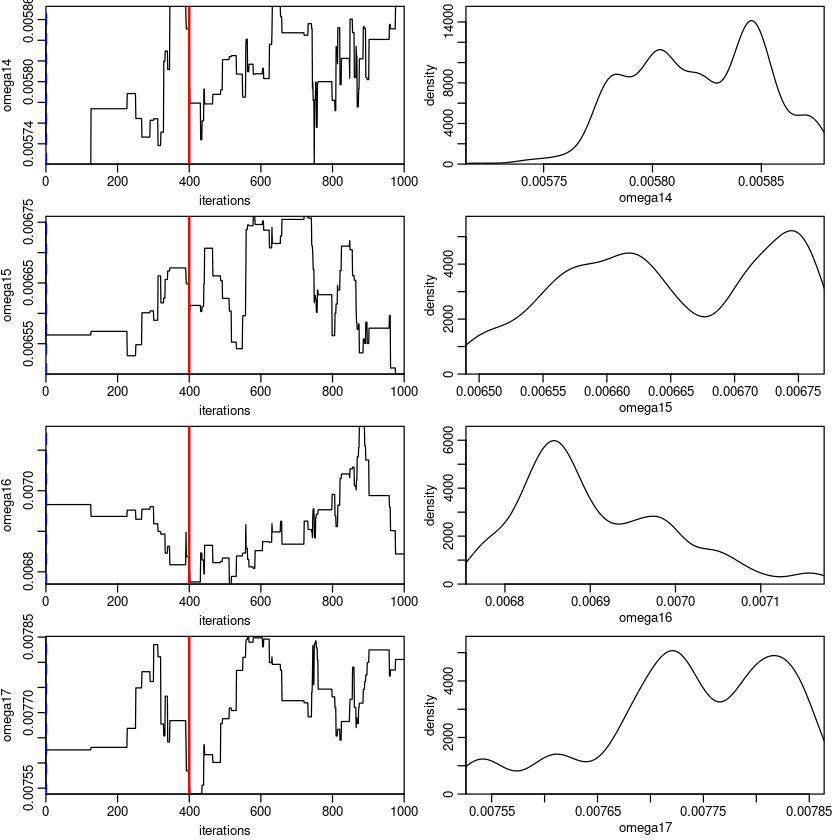

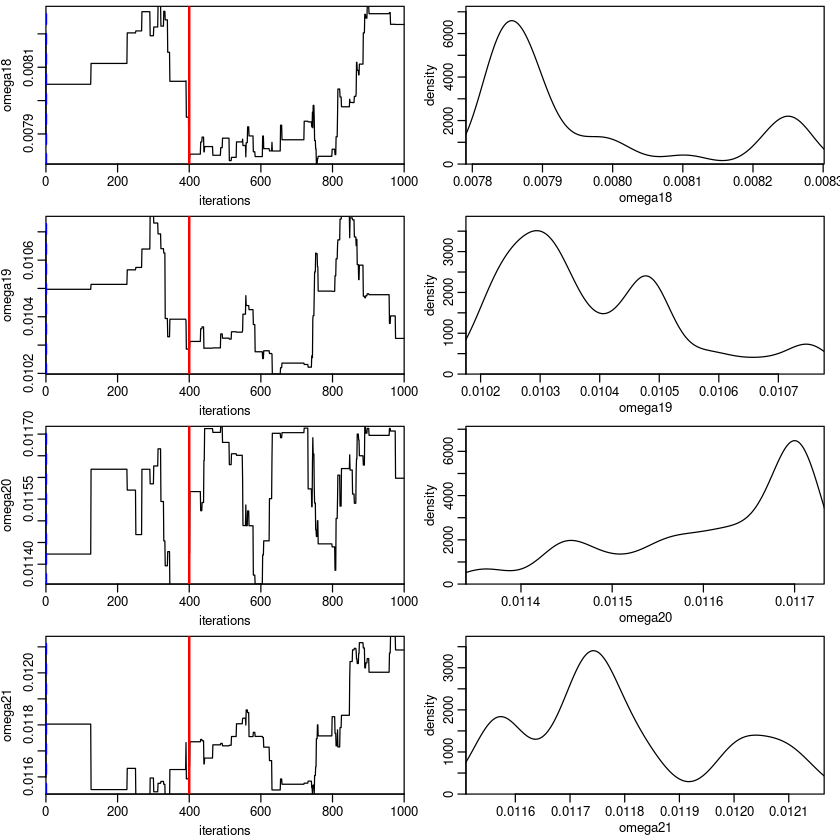

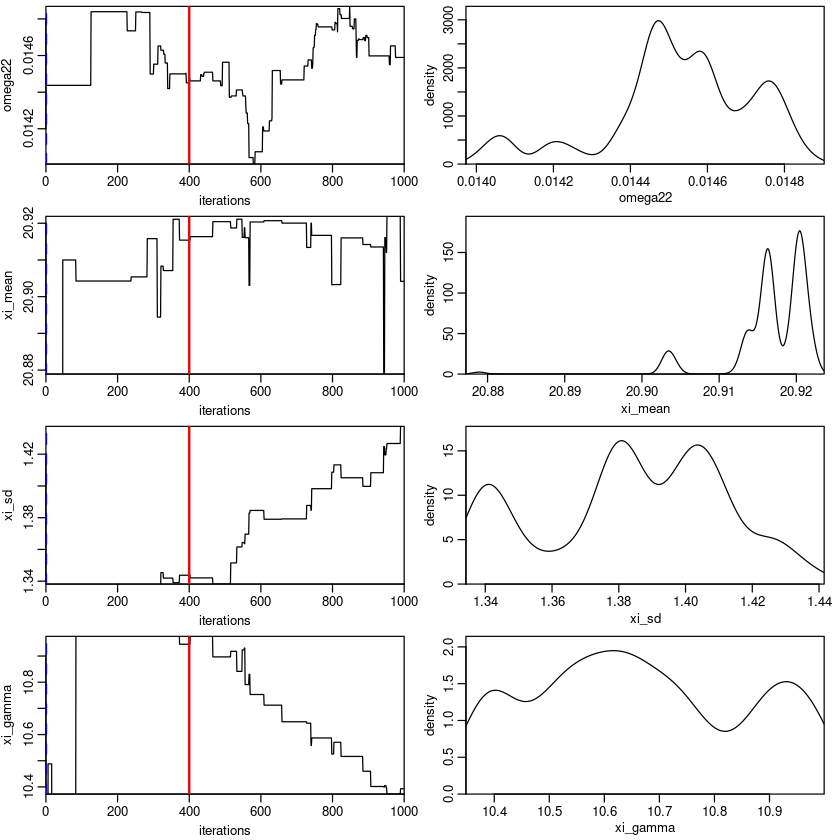

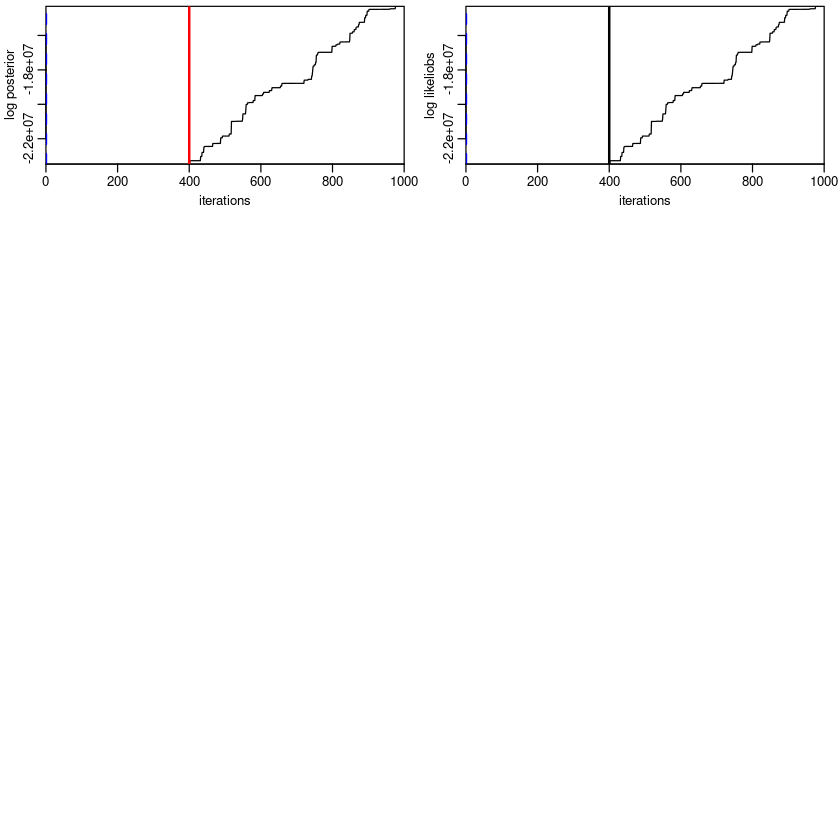

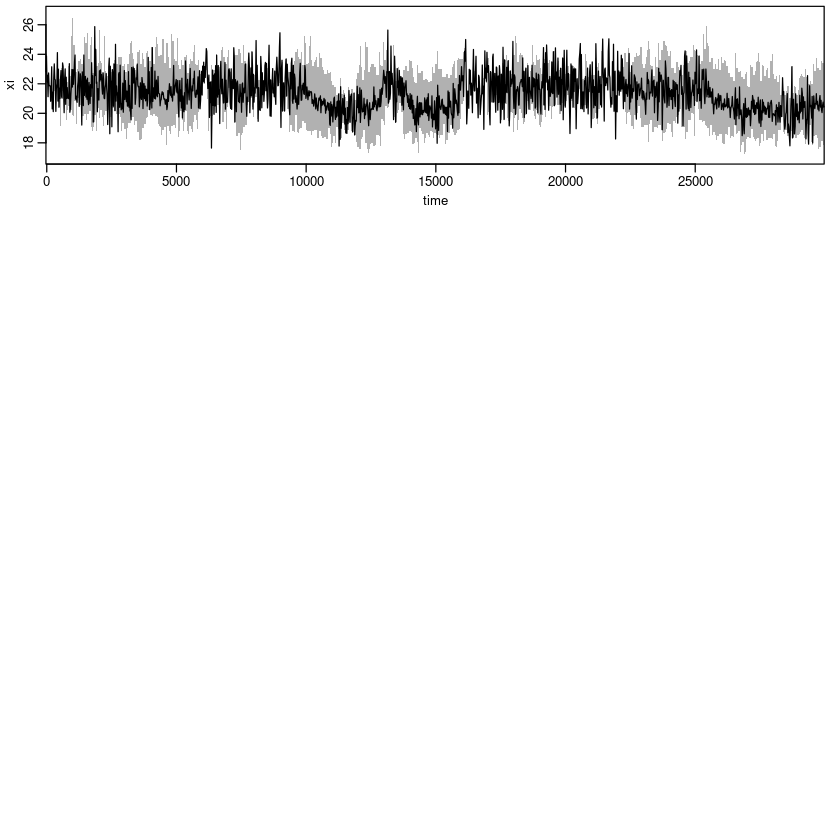

In [3]:
############################################################################
##  δ18O vs stalagmite cycles – multi‑harmonic Bayesian fit  (first 30 kyr)
############################################################################

library(readxl)
library(timedeppar)

### --------------------------------------------------------------------- ###
### 1.  READ THE CATALOGUES                                               ###
### --------------------------------------------------------------------- ###

cols <- c("period","delta_period","amplitude","delta_amplitude",
          "phase","delta_phase","significance")

df_stal  <- read_excel("./data/Borneo Stalagmite 02.04.25.xlsx",
                       range = "N11:T18", col_names = cols)

df_delta <- read_excel("./data/d18O NGRIP 21.04.24.xlsx",
                       sheet = "Spectra d18O",
                       range = "B11:H33", col_names = cols)

## keep ≤ 30 kyr
df_stal  <- subset(df_stal,  period <= 30000)
df_delta <- subset(df_delta, period <= 30000)

### --------------------------------------------------------------------- ###
### 2.  IDENTIFY “REFERENCE” PERIODS  (≤ 2 % difference)                 ###
### --------------------------------------------------------------------- ###

ref_delta_idx <- ref_stal_idx <- integer(0)

for (id in seq_len(nrow(df_delta))){
  for (is in seq_len(nrow(df_stal))){
    rel <- abs(df_delta$period[id] - df_stal$period[is]) /
           df_delta$period[id]
    if (rel <= 0.04){
      ref_delta_idx <- c(ref_delta_idx, id)
      ref_stal_idx  <- c(ref_stal_idx,  is)
    }
  }
}

cat("Locked ω from stalagmites:", length(ref_delta_idx), "\n")

### --------------------------------------------------------------------- ###
### 3.  READ THE RAW d18O TIME SERIES                                    ###
### --------------------------------------------------------------------- ###

raw <- read_excel("./data/d18O NGRIP 21.04.24.xlsx",
                  sheet = "Raw Data",
                  range = "C11:D6124",
                  col_names = c("Age","d18O"))

raw <- raw[raw$Age <= 30000, ]
raw <- raw[order(raw$Age), ]                 # ascending for randOU / diff

### --------------------------------------------------------------------- ###
### 4.  NAMES FOR SCALAR PARAMETERS                                      ###
### --------------------------------------------------------------------- ###

free_idx <- setdiff(seq_len(nrow(df_delta)), ref_delta_idx)

names_A    <- paste0("A",    seq_len(nrow(df_delta)))
names_phi  <- paste0("phi",  seq_len(nrow(df_delta)))
names_omg  <- paste0("omega", free_idx)      # only the *free* ones

### --------------------------------------------------------------------- ###
### 5.  INITIAL VALUES AND RANGES                                        ###
### --------------------------------------------------------------------- ###

A0      <- df_delta$amplitude
phi0    <- df_delta$phase            # already in radians in the Excel
omg0    <- 2*pi / df_delta$period[free_idx]

p.ini <- list(
  sigma_y = 0.2
)

# OU increments ------------------------------------------------------------
times <- raw$Age[-nrow(raw)]                   # grid for xi
xi_init <- randOU(mean  = mean(diff(times)),
                  sd    = sd(diff(times)),
                  gamma = 10,
                  t     = times)
p.ini$xi <- cbind(times, xi_init$y)

# harmonics -----------------------------------------------------------------
for (k in seq_along(names_A)){
  p.ini[[ names_A[k]  ]] <- A0[k]
  p.ini[[ names_phi[k]]] <- phi0[k]
}
for (j in seq_along(names_omg)){
  p.ini[[ names_omg[j] ]] <- omg0[j]
}

# Ranges --------------------------------------------------------------------
pr <- list(
  sigma_y  = c(0.01, 10),
  xi_mean  = c(mean(diff(times))-sd(diff(times)),
               mean(diff(times))+sd(diff(times))),
  xi_sd    = c(0.01, 10),
  xi_gamma = c(1, 20)
)

min_A <- pmax(0, df_delta$amplitude - df_delta$delta_amplitude)
max_A <-             df_delta$amplitude + df_delta$delta_amplitude

for (k in seq_along(names_A)){
  pr[[ names_A[k]  ]] <- c(min_A[k], max_A[k])
  pr[[ names_phi[k]]] <- c(0, 2*pi)
}
for (j in seq_along(names_omg)){
  p0 <- df_delta$period[ free_idx[j] ]
  pr[[ names_omg[j] ]] <- (2*pi / p0) * c(0.97, 1.03)  # ±3 %
}

# log / linear flags --------------------------------------------------------
plog <- c(sigma_y = TRUE, xi = TRUE)
plog <- c(plog,
          setNames(rep(FALSE,length(names_A)+length(names_phi)),
                   c(names_A,names_phi)),
          setNames(rep(TRUE, length(names_omg)), names_omg))

### --------------------------------------------------------------------- ###
### 6.  PRIOR FOR FREE FREQUENCIES (1 % SD)                               ###
### --------------------------------------------------------------------- ###
omega_sd <- 0.01 * omg0
names(omega_sd) <- names_omg

param.logprior <- function(theta){
  if (length(names_omg)==0) return(0)
  sum(dnorm(theta[names_omg], mean = omg0,
                            sd   = omega_sd,
                            log  = TRUE))
}

### --------------------------------------------------------------------- ###
### 7.  LOG‑LIKELIHOOD                                                   ###
### --------------------------------------------------------------------- ###
loglikeli <- function(par, data){

  # Reconstruct corrected time axis ----------------------------
  xi <- par$xi[,2]
  t  <- c(data$Age[1], data$Age[1] + cumsum(xi))

  y_hat <- numeric(length(t))

  # Locked harmonics -------------------------------------------
  if (length(ref_delta_idx)>0){
    for (id in seq_along(ref_delta_idx)){
      k   <- ref_delta_idx[id]
      A   <- par[[ names_A[k]  ]]
      phi <- par[[ names_phi[k]]]
      omg <- 2*pi / df_stal$period[ ref_stal_idx[id] ]
      y_hat <- y_hat + A * cos(omg * t + phi)
    }
  }

  # Free harmonics ---------------------------------------------
  if (length(free_idx)>0){
    for (j in seq_along(free_idx)){
      k   <- free_idx[j]
      A   <- par[[ names_A[k]  ]]
      phi <- par[[ names_phi[k]]]
      omg <- par[[ names_omg[j] ]]
      y_hat <- y_hat + A * cos(omg * t + phi)
    }
  }

  sum(dnorm(data$d18O, mean = y_hat,
            sd   = par$sigma_y,
            log  = TRUE))
}

### --------------------------------------------------------------------- ###
### 8.  RUN MCMC                                                         ###
### --------------------------------------------------------------------- ###

res <- infer.timedeppar(
         loglikeli        = loglikeli,
         data             = raw,            # passes the Age & d18O cols
         param.ini        = p.ini,
         param.ou.ini     = c(xi_mean  = mean(diff(times)),
                              xi_sd    = sd(diff(times)),
                              xi_gamma = 10),
         param.logprior   = param.logprior,
         param.range      = pr,
         param.log        = plog,
         n.iter           = 1000,
         control          = list(n.interval = 50,
                                 n.adapt    = 1000*0.4),
         verbose          = 1)

plot(res, type = c("traces","time-series"));